In [8]:
import numpy as np
import librosa  
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk, messagebox
import threading
import sounddevice as sd
import time
import warnings
warnings.filterwarnings('ignore')

In [10]:
class VoiceprintExtractor:
    def __init__(self, sample_rate=16000, duration=3):
        self.sample_rate = sample_rate
        self.duration = duration
        self.model = self._build_feature_extractor()
        
    def _build_feature_extractor(self):
        inputs = Input(shape=(128, 40))
        x = LSTM(64, return_sequences=True)(inputs)
        x = Dropout(0.3)(x)
        x = LSTM(32)(x)
        x = Dense(64, activation='relu')(x)
        outputs = Dense(32, activation=None)(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam', loss='mse')
        return model
    
    def extract_features(self, audio_data):
        try:
            mfccs = librosa.feature.mfcc(y=audio_data, 
                                        sr=self.sample_rate,
                                        n_mfcc=40)
            mfccs = mfccs.T
            if mfccs.shape[0] < 128:
                mfccs = np.pad(mfccs, ((0, 128 - mfccs.shape[0]), (0, 0)))
            else:
                mfccs = mfccs[:128, :]
            return mfccs
        except Exception as e:
            print(f"Error extracting features: {e}")
            return None
    
    def get_voiceprint(self, audio_data):
        features = self.extract_features(audio_data)
        if features is None:
            return None
        features = np.expand_dims(features, axis=0)
        embedding = self.model.predict(features, verbose=0)
        return embedding.flatten()


class ContextAwareness:
    def __init__(self):
        self.fuzzy_system = self._build_fuzzy_system()
        
    def _build_fuzzy_system(self):
        noise_level = ctrl.Antecedent(np.arange(0, 101, 1), 'noise_level')
        movement = ctrl.Antecedent(np.arange(0, 101, 1), 'movement')
    
        sensitivity = ctrl.Consequent(np.arange(0, 101, 1), 'sensitivity')
        power_mode = ctrl.Consequent(np.arange(0, 101, 1), 'power_mode')
    
        noise_level['low'] = fuzz.trimf(noise_level.universe, [0, 0, 40])
        noise_level['medium'] = fuzz.trimf(noise_level.universe, [20, 50, 80])
        noise_level['high'] = fuzz.trimf(noise_level.universe, [60, 100, 100])
        
        movement['stationary'] = fuzz.trimf(movement.universe, [0, 0, 30])
        movement['walking'] = fuzz.trimf(movement.universe, [20, 50, 80])
        movement['running'] = fuzz.trimf(movement.universe, [70, 100, 100])
    
        sensitivity['low'] = fuzz.trimf(sensitivity.universe, [0, 0, 40])
        sensitivity['medium'] = fuzz.trimf(sensitivity.universe, [30, 50, 70])
        sensitivity['high'] = fuzz.trimf(sensitivity.universe, [60, 100, 100])
        
        power_mode['eco'] = fuzz.trimf(power_mode.universe, [0, 0, 40])
        power_mode['balanced'] = fuzz.trimf(power_mode.universe, [30, 50, 70])
        power_mode['performance'] = fuzz.trimf(power_mode.universe, [60, 100, 100])
        
        rule1 = ctrl.Rule(noise_level['high'], sensitivity['high'])
        rule2 = ctrl.Rule(noise_level['low'], sensitivity['low'])
        rule3 = ctrl.Rule(movement['running'], power_mode['performance'])
        rule4 = ctrl.Rule(movement['stationary'], power_mode['eco'])
        rule5 = ctrl.Rule(movement['walking'] & noise_level['medium'], 
                         (sensitivity['medium'], power_mode['balanced']))
        
        system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
        return ctrl.ControlSystemSimulation(system)
    
    def detect_noise_level(self, audio_data):
        if len(audio_data) > 0:
            energy = np.sqrt(np.mean(np.square(audio_data)))
            noise_level = min(100, max(0, energy * 100))
            return noise_level
        return 0
    
    def detect_movement(self, acceleration_data=None):
        if acceleration_data is None:
            return np.random.uniform(0, 100)
        else:
            movement = np.mean(np.abs(acceleration_data))
            return min(100, max(0, movement * 10))
            
    def adapt_to_context(self, noise_level, movement):
        try:
            self.fuzzy_system.input['noise_level'] = noise_level
            self.fuzzy_system.input['movement'] = movement
            
            self.fuzzy_system.compute()
            sensitivity = self.fuzzy_system.output['sensitivity']
            power_mode = self.fuzzy_system.output['power_mode']
            
            return {
                'sensitivity': sensitivity,
                'power_mode': power_mode
            }
        except Exception as e:
            print(f"Error in fuzzy adaptation: {e}")
            return {
                'sensitivity': 50,  
                'power_mode': 50  
            }

class EnergyOptimizer:
    def __init__(self):
        self.power_states = {
            'sleep': 5,      
            'listening': 14,
            'processing': 25 
        }
        self.current_state = 'sleep'
        self.current_power = self.power_states['sleep']
        
    def optimize_power(self, context_data):
        power_mode = context_data.get('power_mode', 50)
        if power_mode < 30:
            self.set_power_state('sleep')
        elif power_mode < 70:
            self.set_power_state('listening')
        else:
            self.set_power_state('processing')
            
        return self.current_power
        
    def set_power_state(self, state):
        if state in self.power_states:
            self.current_state = state
            self.current_power = self.power_states[state]
            return True
        return False
        
    def estimate_battery_life(self, battery_capacity_mAh=1000, voltage=3.7):
        battery_capacity_mWh = battery_capacity_mAh * voltage
        estimated_hours = battery_capacity_mWh / self.current_power
        return estimated_hours

class EcoContextVoxID:
    def __init__(self):
        self.voiceprint_extractor = VoiceprintExtractor()
        self.context_awareness = ContextAwareness()
        self.energy_optimizer = EnergyOptimizer()
        self.users = {}
        self.current_user = None
        self.sample_rate = 16000
        self.recording = False
        self.audio_data = None
        
    def register_user(self, user_id, audio_data):
        voiceprint = self.voiceprint_extractor.get_voiceprint(audio_data)
        if voiceprint is not None:
            self.users[user_id] = voiceprint
            return True
        return False
        
    def identify_user(self, audio_data):
        if not self.users:
            return None
            
        test_voiceprint = self.voiceprint_extractor.get_voiceprint(audio_data)
        if test_voiceprint is None:
            return None
        best_match = None
        best_score = -1
        
        for user_id, voiceprint in self.users.items():
            similarity = self._cosine_similarity(test_voiceprint, voiceprint)
            if similarity > best_score:
                best_score = similarity
                best_match = user_id
            
        if best_score > 0.7: 
            self.current_user = best_match
            return (best_match, best_score)
        return (None, best_score)
        
    def _cosine_similarity(self, a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        
    def process_context(self, audio_data, acceleration_data=None):
        noise_level = self.context_awareness.detect_noise_level(audio_data)
        movement = self.context_awareness.detect_movement(acceleration_data)
        context_data = self.context_awareness.adapt_to_context(noise_level, movement)
        self.energy_optimizer.optimize_power(context_data)
        
        return context_data
    
    def record_audio(self, duration=3):
        self.recording = True
        samples = int(duration * self.sample_rate)
        self.audio_data = sd.rec(samples, samplerate=self.sample_rate, channels=1, dtype='float32')
        sd.wait()
        self.audio_data = self.audio_data.flatten()
        self.recording = False
        return self.audio_data

    def generate_fake_audio(self, noise_level=0.1):
        return np.random.normal(0, noise_level, int(3 * self.sample_rate))

class VoxIDApp:
    def __init__(self, root):
        self.root = root
        self.root.title("EcoContext VoxID")
        self.root.geometry("800x600")
        self.root.resizable(True, True)
        self.vox_system = EcoContextVoxID()
        
        self.notebook = ttk.Notebook(root)
        self.notebook.pack(fill='both', expand=True, padx=10, pady=10)

        self.register_tab = ttk.Frame(self.notebook)
        self.identify_tab = ttk.Frame(self.notebook)
        self.context_tab = ttk.Frame(self.notebook)
        
        self.notebook.add(self.register_tab, text="Register User")
        self.notebook.add(self.identify_tab, text="Identify User")
        self.notebook.add(self.context_tab, text="Context Simulation")
    
        self._setup_register_tab()
        self._setup_identify_tab()
        self._setup_context_tab()
    
        self.status_var = tk.StringVar()
        self.status_var.set("Ready")
        self.status_bar = ttk.Label(root, textvariable=self.status_var, relief=tk.SUNKEN, anchor=tk.W)
        self.status_bar.pack(side=tk.BOTTOM, fill=tk.X)
    
    def _setup_register_tab(self):
        register_frame = ttk.LabelFrame(self.register_tab, text="Register New User")
        register_frame.pack(fill='both', expand=True, padx=10, pady=10)

        ttk.Label(register_frame, text="User ID:").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.user_id_var = tk.StringVar()
        ttk.Entry(register_frame, textvariable=self.user_id_var).grid(row=0, column=1, padx=5, pady=5, sticky=tk.W)
    
        self.record_button = ttk.Button(register_frame, text="Record Voice Sample", command=self._record_for_registration)
        self.record_button.grid(row=1, column=0, columnspan=2, padx=5, pady=5)

        self.fake_audio_button = ttk.Button(register_frame, text="Generate Fake Audio", command=self._generate_fake_for_registration)
        self.fake_audio_button.grid(row=2, column=0, columnspan=2, padx=5, pady=5)
    
        self.register_button = ttk.Button(register_frame, text="Register User", command=self._register_user, state=tk.DISABLED)
        self.register_button.grid(row=3, column=0, columnspan=2, padx=5, pady=5)

        self.register_status_var = tk.StringVar()
        self.register_status_var.set("")
        ttk.Label(register_frame, textvariable=self.register_status_var).grid(row=4, column=0, columnspan=2, padx=5, pady=5)

        ttk.Label(register_frame, text="Registered Users:").grid(row=5, column=0, padx=5, pady=5, sticky=tk.W)
        self.user_listbox = tk.Listbox(register_frame, height=10)
        self.user_listbox.grid(row=6, column=0, columnspan=2, padx=5, pady=5, sticky=tk.W+tk.E)
    
    def _setup_identify_tab(self):
        identify_frame = ttk.LabelFrame(self.identify_tab, text="Identify User")
        identify_frame.pack(fill='both', expand=True, padx=10, pady=10)
    
        self.identify_record_button = ttk.Button(identify_frame, text="Record Voice Sample", command=self._record_for_identification)
        self.identify_record_button.grid(row=0, column=0, padx=5, pady=5)
    
        self.use_registered_button = ttk.Button(identify_frame, text="Use Registered User Audio", command=self._use_registered_audio)
        self.use_registered_button.grid(row=0, column=1, padx=5, pady=5)

        self.identify_button = ttk.Button(identify_frame, text="Identify User", command=self._identify_user, state=tk.DISABLED)
        self.identify_button.grid(row=1, column=0, columnspan=2, padx=5, pady=5)

        self.identify_result_var = tk.StringVar()
        self.identify_result_var.set("")
        ttk.Label(identify_frame, textvariable=self.identify_result_var, font=('Arial', 12, 'bold')).grid(row=2, column=0, columnspan=2, padx=5, pady=5)

        self.confidence_var = tk.StringVar()
        self.confidence_var.set("")
        ttk.Label(identify_frame, textvariable=self.confidence_var).grid(row=3, column=0, columnspan=2, padx=5, pady=5)
    
    def _setup_context_tab(self):
        context_frame = ttk.LabelFrame(self.context_tab, text="Simulate Context")
        context_frame.pack(fill='both', expand=True, padx=10, pady=10)
        
        ttk.Label(context_frame, text="Noise Level:").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.noise_var = tk.DoubleVar(value=30)
        ttk.Scale(context_frame, from_=0, to=100, variable=self.noise_var, orient=tk.HORIZONTAL, length=300).grid(row=0, column=1, padx=5, pady=5)
    
        ttk.Label(context_frame, text="Movement Level:").grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
        self.movement_var = tk.DoubleVar(value=20)
        ttk.Scale(context_frame, from_=0, to=100, variable=self.movement_var, orient=tk.HORIZONTAL, length=300).grid(row=1, column=1, padx=5, pady=5)
    
        self.simulate_button = ttk.Button(context_frame, text="Simulate Context", command=self._simulate_context)
        self.simulate_button.grid(row=2, column=0, columnspan=2, padx=5, pady=5)
    
        results_frame = ttk.LabelFrame(context_frame, text="Simulation Results")
        results_frame.grid(row=3, column=0, columnspan=2, padx=5, pady=5, sticky=tk.W+tk.E)

        ttk.Label(results_frame, text="Sensitivity:").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.sensitivity_var = tk.StringVar()
        ttk.Label(results_frame, textvariable=self.sensitivity_var).grid(row=0, column=1, padx=5, pady=5, sticky=tk.W)
        
        ttk.Label(results_frame, text="Power Mode:").grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
        self.power_mode_var = tk.StringVar()
        ttk.Label(results_frame, textvariable=self.power_mode_var).grid(row=1, column=1, padx=5, pady=5, sticky=tk.W)
        
        ttk.Label(results_frame, text="Power State:").grid(row=2, column=0, padx=5, pady=5, sticky=tk.W)
        self.power_state_var = tk.StringVar()
        ttk.Label(results_frame, textvariable=self.power_state_var).grid(row=2, column=1, padx=5, pady=5, sticky=tk.W)
        
        ttk.Label(results_frame, text="Power Usage:").grid(row=3, column=0, padx=5, pady=5, sticky=tk.W)
        self.power_usage_var = tk.StringVar()
        ttk.Label(results_frame, textvariable=self.power_usage_var).grid(row=3, column=1, padx=5, pady=5, sticky=tk.W)
        
        ttk.Label(results_frame, text="Battery Life:").grid(row=4, column=0, padx=5, pady=5, sticky=tk.W)
        self.battery_life_var = tk.StringVar()
        ttk.Label(results_frame, textvariable=self.battery_life_var).grid(row=4, column=1, padx=5, pady=5, sticky=tk.W)
        
        self.fig, self.ax = plt.subplots(figsize=(5, 3))
        self.canvas_frame = ttk.Frame(context_frame)
        self.canvas_frame.grid(row=4, column=0, columnspan=2, padx=5, pady=5)
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.canvas_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    
    def _record_for_registration(self):
        self.status_var.set("Recording... Speak now")
        self.root.update()
        try:
            def record():
                audio_data = self.vox_system.record_audio()
                self.status_var.set("Recording complete")
                self.register_button.config(state=tk.NORMAL)
            
            threading.Thread(target=record).start()
        except Exception as e:
            messagebox.showerror("Error", f"Recording failed: {str(e)}")
            self.status_var.set("Recording failed")
    
    def _generate_fake_for_registration(self):
        self.status_var.set("Generating fake audio...")
        self.vox_system.audio_data = self.vox_system.generate_fake_audio()
        self.status_var.set("Fake audio generated")
        self.register_button.config(state=tk.NORMAL)
    
    def _register_user(self):
        user_id = self.user_id_var.get().strip()
        if not user_id:
            messagebox.showerror("Error", "Please enter a user ID")
            return
            
        if not self.vox_system.audio_data is not None:
            messagebox.showerror("Error", "No audio data available")
            return
            
        success = self.vox_system.register_user(user_id, self.vox_system.audio_data)
        if success:
            self.register_status_var.set(f"User {user_id} registered successfully")
            self.user_listbox.insert(tk.END, user_id)
            self.user_id_var.set("")
        else:
            self.register_status_var.set(f"Failed to register user {user_id}")
        
        self.register_button.config(state=tk.DISABLED)
    
    def _record_for_identification(self):
        self.status_var.set("Recording... Speak now")
        self.root.update()
        try:
            def record():
                audio_data = self.vox_system.record_audio()
                self.status_var.set("Recording complete")
                self.identify_button.config(state=tk.NORMAL)
            
            threading.Thread(target=record).start()
        except Exception as e:
            messagebox.showerror("Error", f"Recording failed: {str(e)}")
            self.status_var.set("Recording failed")
    
    def _use_registered_audio(self):
        if len(self.vox_system.users) == 0:
            messagebox.showerror("Error", "No users registered")
            return

        user_id = list(self.vox_system.users.keys())[0]
        self.vox_system.audio_data = self.vox_system.generate_fake_audio()
        self.status_var.set(f"Using simulated audio similar to user: {user_id}")
        self.identify_button.config(state=tk.NORMAL)
    
    def _identify_user(self):
        if self.vox_system.audio_data is None:
            messagebox.showerror("Error", "No audio data available")
            return
            
        user, confidence = self.vox_system.identify_user(self.vox_system.audio_data)
        if user:
            self.identify_result_var.set(f"Identified User: {user}")
            self.confidence_var.set(f"Confidence: {confidence:.2f}")
        else:
            self.identify_result_var.set("No match found")
            self.confidence_var.set(f"Best match score: {confidence:.2f}")
            
        self.identify_button.config(state=tk.DISABLED)
    
    def _simulate_context(self):
        noise_level = self.noise_var.get()
        movement_level = self.movement_var.get()
    
        noise_factor = noise_level / 200 
        audio_data = self.vox_system.generate_fake_audio(noise_level=noise_factor)
        context_result = self.vox_system.process_context(
            audio_data,
            np.array([movement_level/10])
        )
        self.sensitivity_var.set(f"{context_result['sensitivity']:.1f}/100")
        self.power_mode_var.set(f"{context_result['power_mode']:.1f}/100")
        self.power_state_var.set(self.vox_system.energy_optimizer.current_state)
        self.power_usage_var.set(f"{self.vox_system.energy_optimizer.current_power} mW")
        battery_life = self.vox_system.energy_optimizer.estimate_battery_life()
        self.battery_life_var.set(f"{battery_life:.1f} hours")
        self._update_context_plot(noise_level, movement_level, context_result)
    
    def _update_context_plot(self, noise, movement, context_result):
        self.ax.clear()
        labels = ['Noise', 'Movement', 'Sensitivity', 'Power Mode']
        values = [noise, movement, context_result['sensitivity'], context_result['power_mode']]
        colors = ['blue', 'green', 'orange', 'red']
        self.ax.bar(labels, values, color=colors)
        self.ax.set_ylim(0, 100)
        self.ax.set_ylabel('Level (0-100)')
        self.ax.set_title('Context Parameters')
        self.fig.tight_layout()
        self.canvas.draw()

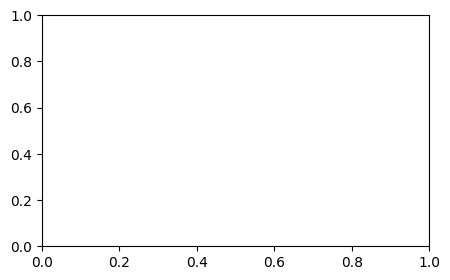

In [12]:
def main():
    root = tk.Tk()
    app = VoxIDApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()